# Cohort 60x60 AUCs analysis

### Imports and environment setup

- Date of run: 2024-12-28
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [17]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [18]:
# Library imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Utils imports
import cohort_analysis_utils as utils

In [19]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file was saved into a CSV file in the data folder of this repository, separating fields by TABs.

In [20]:
df_120 = pd.read_csv('../data/60x60_dr_mmk_20250224.csv' , sep='\t', index_col=0, header=0)


In [21]:
# Harmonization of column names
df_120 = utils.normalize_column_names(df_120)

In [25]:
# Ensure numeric columns are treated as such
cols_120_to_num = ['Collected_volume_mL', 'pH',
                    'MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'AGRIN', 'KPYM', 'PIGR', 'Total_protein_BCA']
df_120 = utils.cols_as_numbers(df_120, cols_120_to_num)

In [26]:
# Columns to be considered as biomarkers
BIOMARKERS_120 = ['MMP9', 'HSPB1', 'PERM', 'ADIPOQ', 'TIMP-2', 'AGRIN', 'KPYM', 'PIGR']


### Create new columns for biomarker ratios

In [27]:
# Create new columns with the ratios between the biomarkers
for biomarker1 in BIOMARKERS_120:
    for biomarker2 in BIOMARKERS_120:
        if biomarker1 != biomarker2:
            df_120[f'{biomarker1}_{biomarker2}'] = df_120[biomarker1].div(df_120[biomarker2], axis=0)
            # Make infinite values NaN
            df_120[f'{biomarker1}_{biomarker2}'] = df_120[f'{biomarker1}_{biomarker2}'].replace([np.inf, -np.inf], np.nan)
    

In [28]:
# Ensure categorical columns are treated as such
df_120 = utils.cols_as_category(df_120, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

# Execution parameters

In [29]:
PLOT_ROCS = False
MAX_BIOMARKER_COUNT = 3
RESULTS_PATH = '../data/results/60x60_dr_ratios_mmk_pigr'

# The biomarkers now include the ratios
BIOMARKERS_120 = [f"{biomarker1}_{biomarker2}" for biomarker1 in BIOMARKERS_120 for biomarker2 in BIOMARKERS_120 if biomarker1 != biomarker2]

NORMALIZING_COL_120 = 'Total_protein_BCA' # Column to be used for normalizing the biomarkers
VOLUME_COL = 'Collected_volume_mL' # Column to be used as volume for scatters and undoing the dilution

Since we are using ratios, we are interested only in the $direct$ method.

In [30]:
METHODS = ['direct']

# Computing the models

All the functions to generate the models are included in the [cohort_analysis_utils.py](../code/cohort_analysis_utils.py) file.

In [37]:
models_120 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=1,
                            folder_name=RESULTS_PATH,
                            plot_rocs=True,
                            auc_threshold=0.0,
                            )

In [28]:
models_120['direct'][list(models_120['direct'].keys())[0]][('TIMP-2_MMP9', 'AGRIN_MMP9')]['auc']

0.875

In [38]:
utils.plot_combo_roc_to_file(models_120['direct'][list(models_120['direct'].keys())[0]][('TIMP-2_MMP9', 'AGRIN_MMP9')], '/home/leandro/Desktop/models/mod')

In [ ]:
for MAX_BIOMARKER_COUNT in range(2, 5):
    print(f"Computing models with {MAX_BIOMARKER_COUNT} biomarkers")
    models_120 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=True,
                            auc_threshold=0.75,
                            )

Let's do the same for single biomarkers.

In [37]:
MAX_BIOMARKER_COUNT = 1

models_120_1 = utils.compute_all_models_and_save(
                            df=df_120,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            compute_auc_ci=True
                            )

# Results

Given the number of models computed for different amounts of ratios, AUC results are not shown here but saved in the correspondent results folder.

## AUCs confidence interval

AUCs confidence intervals are computed with the bootstraping method. Bootstrapping to compute confidence intervals for AUC involves repeatedly resampling the original dataset with replacement to create many bootstrap samples, calculating the AUC for each sample, and then constructing a distribution of these AUC values. The confidence interval is determined by taking the appropriate percentiles (e.g., 2.5th and 97.5th for a 95% CI) from the sorted bootstrap AUC values, providing a range that estimates where the true AUC likely falls.

In [13]:
aucs = []
auc_cis = []
models = []

for model in models_120_1['direct'][(list(models_120_1['direct'].keys())[0])].keys():
    model_name = model[0]
    model_auc = models_120_1['direct'][(list(models_120_1['direct'].keys())[0])][model]['auc']
    model_auc_ci = models_120_1['direct'][(list(models_120_1['direct'].keys())[0])][model]['auc_ci']
    aucs.append(float(model_auc))
    auc_cis.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
    models.append(model_name)

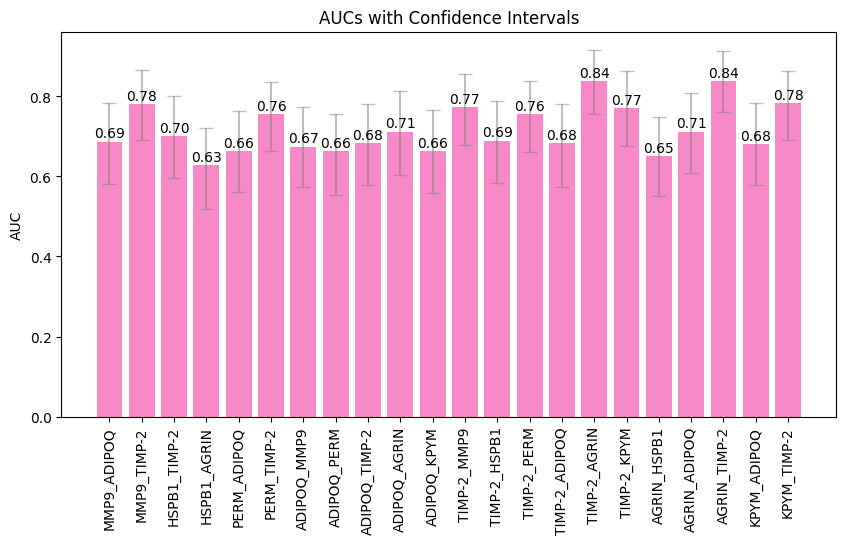

In [14]:
custom_palette = {0: "#f789c8", 1: "#f41c11"}  # Use MMK colors

auc_cis = np.array(auc_cis)

# Calculate the errors
lower_err = aucs - auc_cis[:, 0]
upper_err = auc_cis[:, 1] - aucs
yerr = [lower_err, upper_err]

plt.figure(figsize=(10,5))
plt.bar(
    models,
    aucs,
    yerr=yerr,
    capsize=5,
    align='center',
    color=custom_palette[0],
    error_kw={'elinewidth': 1.5, 'alpha': 0.5, 'ecolor': 'gray'}  # Customize error bars
)

# Add text with the value of the bar in the top center of the error bars
for i in range(len(models)):
    plt.text(i, aucs[i] + 0.01, f'{aucs[i]:.2f}', ha='center')


plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUCs with Confidence Intervals')
plt.show()

## Removing outliers

They were computed in the dr validation notebook and transplanted here.

In [29]:
outliers = ['012-0008',
'003-0039',
'003-0035',
'003-0062',
'006-0009',
'007-0011',
'005-0007',
'018-0016',
'012-0005',
'006-0001',
'003-0047',
'002-0022']

In [30]:
df_120_cleaned = df_120.drop(outliers)


In [38]:
MAX_BIOMARKER_COUNT = 1
RESULTS_PATH = '../data/results/60x60_dr_ratios_mmk_no_outliers'

models_120_1_no_outliers = utils.compute_all_models_and_save(
                            df=df_120_cleaned,
                            biomarkers=BIOMARKERS_120,
                            normalizing_col=NORMALIZING_COL_120, 
                            volume_col= VOLUME_COL,
                            volume_added=0.5,
                            apply_log=True,
                            avoid_same_biomarker=True,
                            methods=METHODS,
                            max_biomarker_count=MAX_BIOMARKER_COUNT,
                            folder_name=RESULTS_PATH,
                            plot_rocs=PLOT_ROCS,
                            compute_auc_ci=True
                            )

In [39]:
aucs = []
auc_cis = []
models = []

for model in models_120_1['direct'][(list(models_120_1['direct'].keys())[0])].keys():
    model_name = model[0]
    model_auc = models_120_1['direct'][(list(models_120_1['direct'].keys())[0])][model]['auc']
    model_auc_ci = models_120_1['direct'][(list(models_120_1['direct'].keys())[0])][model]['auc_ci']
    aucs.append(float(model_auc))
    auc_cis.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
    models.append(model_name)

# Do the same for models_120_1_no_outliers
aucs_no_outliers = []
auc_cis_no_outliers = []
models_no_outliers = []

for model in models_120_1_no_outliers['direct'][(list(models_120_1_no_outliers['direct'].keys())[0])].keys():
    model_name = model[0]
    model_auc = models_120_1_no_outliers['direct'][(list(models_120_1_no_outliers['direct'].keys())[0])][model]['auc']
    model_auc_ci = models_120_1_no_outliers['direct'][(list(models_120_1_no_outliers['direct'].keys())[0])][model]['auc_ci']
    aucs_no_outliers.append(float(model_auc))
    auc_cis_no_outliers.append([float(model_auc_ci[0]), float(model_auc_ci[1])])
    models_no_outliers.append(model_name)
    

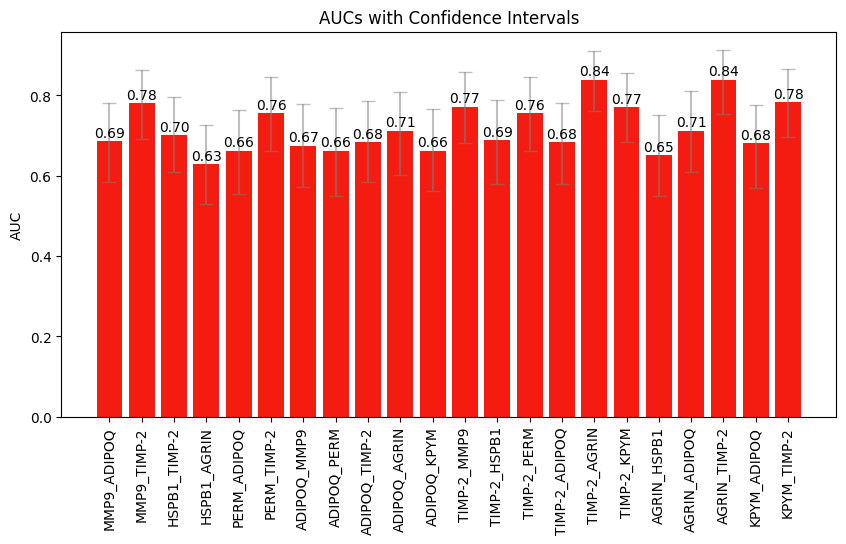

In [43]:
custom_palette = {0: "#f789c8", 1: "#f41c11"}  # Use MMK colors

auc_cis = np.array(auc_cis)

# Calculate the errors
lower_err = aucs - auc_cis[:, 0]
upper_err = auc_cis[:, 1] - aucs
yerr = [lower_err, upper_err]

plt.figure(figsize=(10,5))
plt.bar(
    models,
    aucs,
    yerr=yerr,
    capsize=5,
    align='center',
    color=custom_palette[1],
    error_kw={'elinewidth': 1.5, 'alpha': 0.5, 'ecolor': 'gray'}  # Customize error bars
)

# Add text with the value of the bar in the top center of the error bars
for i in range(len(models)):
    plt.text(i, aucs[i] + 0.01, f'{aucs[i]:.2f}', ha='center')


plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('AUCs with Confidence Intervals')
plt.show()

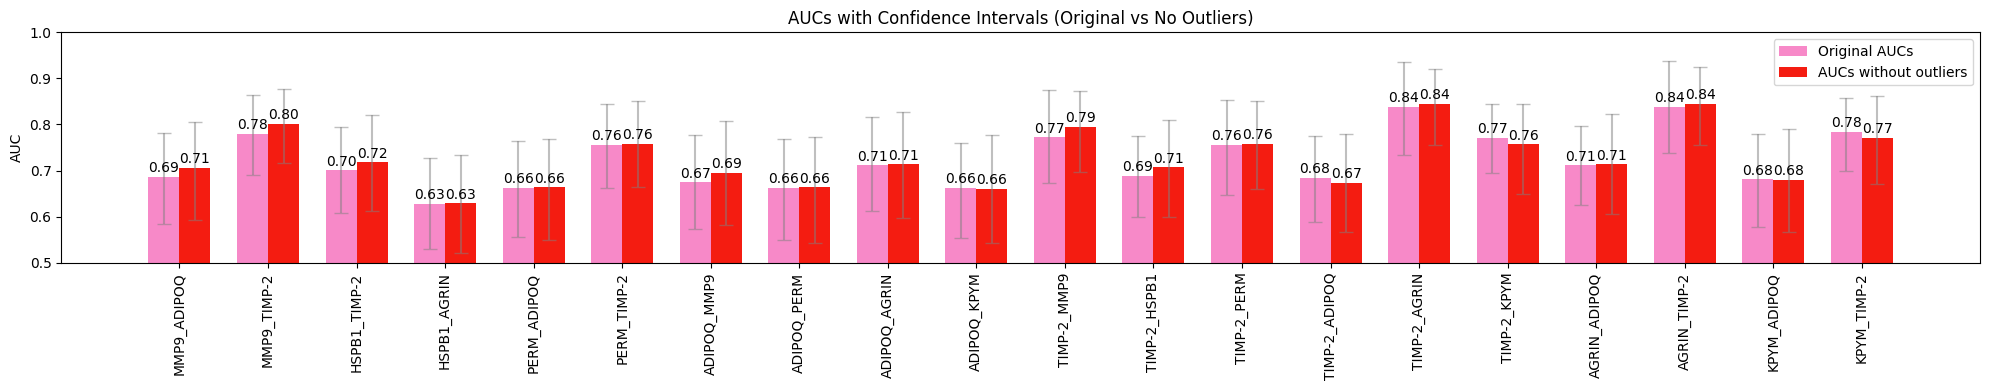

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Find the intersection of models
common_models = list(set(models).intersection(models_no_outliers))

# Sort the common models by their original order
common_models.sort(key=lambda x: models.index(x))

# Filter AUCs and errors for common models
indices_models = [models.index(m) for m in common_models]
indices_models_no_outliers = [models_no_outliers.index(m) for m in common_models]

aligned_aucs = [aucs[i] for i in indices_models]
aligned_aucs_no_outliers = [aucs_no_outliers[i] for i in indices_models_no_outliers]

aligned_yerr = [
    [yerr[0][i] for i in indices_models],  # Lower errors for original
    [yerr[1][i] for i in indices_models]   # Upper errors for original
]

aligned_yerr_no_outliers = [
    [yerr_no_outliers[0][i] for i in indices_models_no_outliers],  # Lower errors for no outliers
    [yerr_no_outliers[1][i] for i in indices_models_no_outliers]   # Upper errors for no outliers
]

# Plotting grouped bars
plt.figure(figsize=(20, 4))

bar_width = 0.35
x = np.arange(len(common_models))  # X positions for common models

# Plot original AUCs
plt.bar(
    x - bar_width / 2,
    aligned_aucs,
    yerr=aligned_yerr,
    capsize=5,
    color=custom_palette[0],
    width=bar_width,
    label='Original AUCs',
    error_kw={'elinewidth': 1.5, 'alpha': 0.5, 'ecolor': 'gray'}
)

# Plot no-outlier AUCs
plt.bar(
    x + bar_width / 2,
    aligned_aucs_no_outliers,
    yerr=aligned_yerr_no_outliers,
    capsize=5,
    color=custom_palette[1],
    width=bar_width,
    label='AUCs without outliers',
    error_kw={'elinewidth': 1.5, 'alpha': 0.5, 'ecolor': 'gray'}
)

# Add AUC values as text
for i in range(len(common_models)):
    plt.text(x[i] - bar_width / 2, aligned_aucs[i] + 0.01, f"{aligned_aucs[i]:.2f}", ha='center')
    plt.text(x[i] + bar_width / 2, aligned_aucs_no_outliers[i] + 0.01, f"{aligned_aucs_no_outliers[i]:.2f}", ha='center')

# Finalize plot
plt.xticks(x, common_models, rotation=90)
plt.ylabel('AUC')
# Set x-range from 0.5 to 1
plt.ylim(0.5, 1) 
plt.title('AUCs with Confidence Intervals (Original vs No Outliers)')
plt.legend()
plt.tight_layout()
plt.show()
